In [123]:
#Import Statement
from datetime import date
import holidays
import pandas as pd
import tensorflow as tf
from math import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
import io
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, LeakyReLU, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

In [2]:
uploaded = files.upload()

Saving electricity_demand.csv to electricity_demand.csv


In [44]:
#Fetch the dataset
dataset = pd.read_csv(io.BytesIO(uploaded['electricity_demand.csv']))
dataset.head()

,date,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,1/1/2015,99635.030,25.633696,13.3,5.186521,0.000000,0.0,N,Y
1,1/2/2015,129606.010,33.138988,15.4,6.228965,0.880597,0.0,N,N
2,1/3/2015,142300.540,34.564855,20.0,6.180615,1.011321,0.0,N,N
3,1/4/2015,104330.715,25.005560,16.3,4.626013,1.051587,4.2,N,N
4,1/5/2015,118132.200,26.724176,15.0,4.690416,0.820847,0.0,N,N


In [45]:
#Format the date column of the dataset
dataset['date'] = pd.to_datetime(dataset['date'], infer_datetime_format=True)

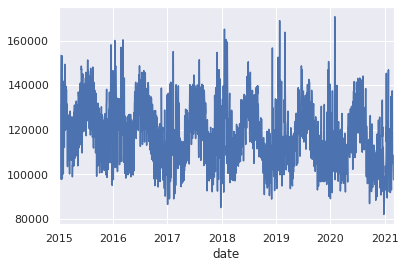

In [46]:
#Plot the electricity demand using date column
dataset.set_index('date')['demand'].plot()

In [47]:
#Display information about the electricity demand dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2251 non-null   datetime64[ns]
 1   demand           2251 non-null   float64       
 2   RRP              2251 non-null   float64       
 3   min_temperature  2251 non-null   float64       
 4   max_temperature  2251 non-null   float64       
 5   solar_exposure   2251 non-null   float64       
 6   rainfall         2251 non-null   float64       
 7   school_day       2251 non-null   object        
 8   holiday          2251 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 158.4+ KB


In [48]:
#Display the number of rows in dataset
dataset.count()

date               2251
demand             2251
RRP                2251
min_temperature    2251
max_temperature    2251
solar_exposure     2251
rainfall           2251
school_day         2251
holiday            2251
dtype: int64

In [49]:
#Set the date column as index
dataset.set_index('date', inplace=True)

In [50]:
#Replace the school day and holiday with appropriate values
dataset['school_day'] = dataset['school_day'].replace(to_replace ="N", value = 0)
dataset['school_day'] = dataset['school_day'].replace(to_replace ="Y", value = 1)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="N", value = 0)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="Y", value = 1)

In [51]:
#Split the dataset to form training and testing set
training_set = dataset.iloc[:2191]
testing_set = dataset.iloc[2192:]

In [89]:
#Display the training and testing dataset
print("Training dataset: \n", training_set.tail())
print("\nTesting dataset: \n", testing_set.head())

Training dataset: 
                demand        RRP  ...  school_day  holiday
date                              ...                     
2020-12-26  88980.895  31.239583  ...           0        0
2020-12-27  96137.560   6.380417  ...           0        0
2020-12-28  85792.090   8.254583  ...           0        1
2020-12-29  90537.375  23.902917  ...           0        0
2020-12-30  93732.335  29.288958  ...           0        0

[5 rows x 8 columns]

Testing dataset: 
                 demand        RRP  ...  school_day  holiday
date                               ...                     
2021-01-01   92926.685  18.296383  ...           0        1
2021-01-02   98995.065  21.890208  ...           0        0
2021-01-03   94371.480  19.487708  ...           0        0
2021-01-04   99640.535   4.791042  ...           0        0
2021-01-05  103840.455   7.464583  ...           0        0

[5 rows x 8 columns]


In [88]:
#Display the shape of the training and testing dataset
print("Training dataset shape: ", training_set.shape)
print("Testing dataset shape: ", testing_set.shape)

Training dataset shape:  (2191, 8)
Testing dataset shape:  (59, 8)


In [83]:
#Employ Information Criterion Akaike (AIC) as a model selection criterion
forecasting_model = VAR(training_set)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

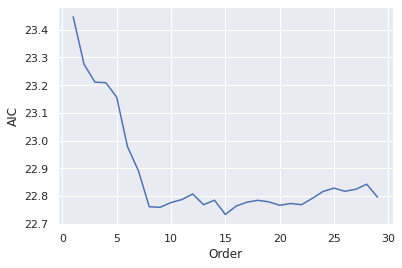

In [84]:
#Plot the AIC and order
sns.set()
plt.plot(list(np.arange(1,30,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [66]:
#Train the VAR model using order '15'
results = forecasting_model.fit(15)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     10:10:50
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    25.2627
Nobs:                     2176.00    HQIC:                   23.6583
Log likelihood:          -48467.0    FPE:                7.47260e+09
AIC:                      22.7336    Det(Omega_mle):     4.84680e+09
--------------------------------------------------------------------
Results for equation demand
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   39744.058111      6199.673925            6.411           0.000
L1.demand                   0.823539         0.024034           34.265           0.000
L1.RRP                      3.70341

In [73]:
#Forecast the electricity demand for 59 days (January and February 2021)
print(results.k_ar)
laaged_values = training_set.values[-results.k_ar:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=59), index = testing_set.index)
forecast

15


,0,1,2,3,4,5,6,7
date,,,,,,,,
2021-01-01,98963.695263,-13.767266,12.832427,4.884844,0.953007,1.280129,0.093304,0.154526
2021-01-02,98089.291266,83.619691,12.815915,4.540559,1.400540,0.339981,0.162511,-0.029336
2021-01-03,92696.304948,158.525314,12.149436,4.854530,0.942241,1.032070,0.044116,0.047715
2021-01-04,92868.629292,80.606607,13.577324,4.856301,1.067248,5.689020,0.038793,0.009797
2021-01-05,105995.983103,55.668282,13.561114,4.822440,1.014104,-0.948197,0.106658,0.024459
2021-01-06,107469.383007,36.042340,13.305462,4.967136,1.618576,1.361348,0.185061,0.024790
2021-01-07,111077.099846,45.705137,14.819407,4.929254,1.343474,1.480124,0.109608,-0.058362
2021-01-08,106613.888353,49.526038,13.815456,4.841144,0.629754,2.169921,0.186796,0.049915
2021-01-09,106304.889510,27.479025,13.571103,4.898035,1.794833,1.222183,0.207975,0.067520


In [69]:
#Combine the original demand and forecasted demand
output = pd.DataFrame()
output['demand'] = testing_set['demand']
output['forecasted_demand'] = forecast[0]

In [70]:
output

,demand,forecasted_demand
date,,
2021-01-01,92926.685,98963.695263
2021-01-02,98995.065,98089.291266
2021-01-03,94371.480,92696.304948
2021-01-04,99640.535,92868.629292
2021-01-05,103840.455,105995.983103
2021-01-06,100748.620,107469.383007
2021-01-07,100672.950,111077.099846
2021-01-08,103763.200,106613.888353
2021-01-09,106315.210,106304.889510


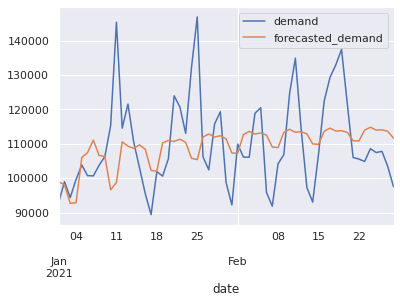

In [71]:
#Plot the demand and forecasted demand
output.plot()

In [87]:
#Performance metric
print("Mean Absolute Error: ", mean_absolute_error(output['demand'],output['forecasted_demand']))
print("Mean Absolute Percentage Error: ", np.mean(np.abs((output['demand'] - output['forecasted_demand']) / output['demand'])) * 100)
print("Mean Squared Error: ", mean_squared_error(output['demand'],output['forecasted_demand']))
print("Root Mean Squared Error: ", sqrt(mean_squared_error(output['demand'],output['forecasted_demand'])))

Mean Absolute Error:  10111.69206205011
Mean Absolute Percentage Error:  8.914966107210857
Mean Squared Error:  177982084.60728446
Root Mean Squared Error:  13340.992639503422


In [145]:
#Split the dataset into the training and testing set
training_set = dataset.iloc[:2191]
training_set_target = training_set['demand']
training_set = training_set.drop(columns=['demand'])

testing_set = dataset.iloc[2192:]
testing_set_target = testing_set['demand']
testing_set = testing_set.drop(columns=['demand'])

#Convert the series to dataframe
training_set_target = pd.DataFrame(training_set_target)
testing_set_target = pd.DataFrame(testing_set_target)

In [146]:
#Display the training and testing dataset
print("Training dataset:\n", training_set.head())
print("\nTraining target dataset:\n", training_set_target.head())
print("\nTesting dataset:\n", testing_set.head())
print("\nTesting target dataset:\n",testing_set_target.head())

Training dataset:
                   RRP  min_temperature  ...  school_day  holiday
date                                    ...                     
2015-01-01  25.633696             13.3  ...           0        1
2015-01-02  33.138988             15.4  ...           0        0
2015-01-03  34.564855             20.0  ...           0        0
2015-01-04  25.005560             16.3  ...           0        0
2015-01-05  26.724176             15.0  ...           0        0

[5 rows x 7 columns]

Training target dataset:
                 demand
date                  
2015-01-01   99635.030
2015-01-02  129606.010
2015-01-03  142300.540
2015-01-04  104330.715
2015-01-05  118132.200

Testing dataset:
                   RRP  min_temperature  ...  school_day  holiday
date                                    ...                     
2021-01-01  18.296383             14.3  ...           0        1
2021-01-02  21.890208             16.8  ...           0        0
2021-01-03  19.487708             17.

In [147]:
#Import statement
from sklearn.preprocessing import MinMaxScaler

#Normalize the dataset using MinMax scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)

training_set_target = scaler_y.fit_transform(training_set_target)
testing_set_target = scaler_y.fit_transform(testing_set_target)

In [148]:
print("Training dataset shape: ", training_set.shape)
print("Training dataset target shape: ", training_set_target.shape)

print("Testing dataset shape:", testing_set.shape)
print("Testing dataset target shape: ",testing_set_target.shape)

Training dataset shape:  (2191, 7)
Training dataset target shape:  (2191, 1)
Testing dataset shape: (59, 7)
Testing dataset target shape:  (59, 1)


In [149]:
training_set = np.reshape(training_set, (training_set.shape[0], 1, training_set.shape[1]))
testing_set = np.reshape(testing_set, (testing_set.shape[0], 1, testing_set.shape[1]))

In [150]:
print("Training dataset shape: ", training_set.shape)
print("Training dataset target shape: ", training_set_target.shape)

print("Testing dataset shape:", testing_set.shape)
print("Testing dataset target shape: ",testing_set_target.shape)

Training dataset shape:  (2191, 1, 7)
Training dataset target shape:  (2191, 1)
Testing dataset shape: (59, 1, 7)
Testing dataset target shape:  (59, 1)


In [177]:
#Design the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape= (2191, 7), return_sequences=False))
model.add(Dense(1))

In [152]:
#Display the summary of LSTM model
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)
model.compile(loss='mean_absolute_error',
              optimizer='adam')

history = model.fit(x=training_set, y=training_set_target, epochs=100, shuffle=False, batch_size=313, callbacks=[callback])

Epoch 1/100
7/7 [==============================] - 2s 10ms/step - loss: 0.4624
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.3830
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.3040
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2308
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1779
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1515
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1441
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1416
Epoch 9/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1392
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 11/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1404
Epoch 12/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1400
Epoch 13/100
7/7 [==============================] - 0s 8ms

In [154]:
#Predict the electricity demand for training and test dataset
train_pred = model.predict(training_set)
test_pred = model.predict(testing_set)

In [155]:
#Apply inverse transformation to the predictions

train_pred = scaler_y.inverse_transform(train_pred)
training_set_target = scaler_y.inverse_transform(training_set_target)
test_pred = scaler_y.inverse_transform(test_pred)
testing_set_target = scaler_y.inverse_transform(testing_set_target)

In [164]:
print(train_pred[:,0])

[ 98978.19  107018.1   106319.37  ... 100554.31  111186.01  110055.055]


In [166]:
#Performance metric
print("Mean Absolute Error: ", mean_absolute_error(training_set_target[:,0], train_pred[:,0]))
print("Mean Absolute Percentage Error: ", np.mean(np.abs((training_set_target[:,0] - train_pred[:,0]) / training_set_target[:,0])) * 100)
print("Mean Squared Error: ", mean_squared_error(training_set_target[:,0], train_pred[:,0]))
print("Root Mean Squared Error: ", sqrt(mean_squared_error(training_set_target[:,0], train_pred[:,0])))

Mean Absolute Error:  6509.232588379873
Mean Absolute Percentage Error:  5.7129730683544455
Mean Squared Error:  68282761.27091458
Root Mean Squared Error:  8263.338385357009


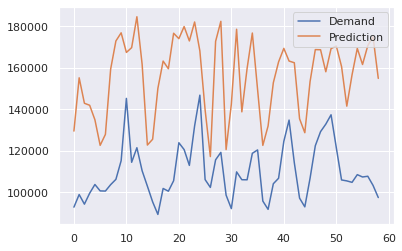

In [173]:
# plot baseline and predictions
plt.plot(testing_set_target)
plt.plot(test_pred)
plt.legend(['Demand', 'Prediction'])
plt.show()